In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from modules import *

In [5]:
buses, branches, load, pv, wind, params = read_data()
for key in ['c_ccgt', 'c_pv', 'c_wind', 'c_stor_energy', 'c_stor_power', 'c_tran', 'd_ccgt', 'd_shed']:
    params[key] = params[key] * 1e-5

PV shape  (240, 5)
Wind shape  (240, 5)
Load shape  (240, 5)


In [3]:
# Load results from the pickle file
with open('cep_results_v2.pkl', 'rb') as f:
    loaded_results = pickle.load(f)


In [7]:
obj = loaded_results["objective"]
print(f"Objective function value: {obj}")

Objective function value: 2193.0782698778685


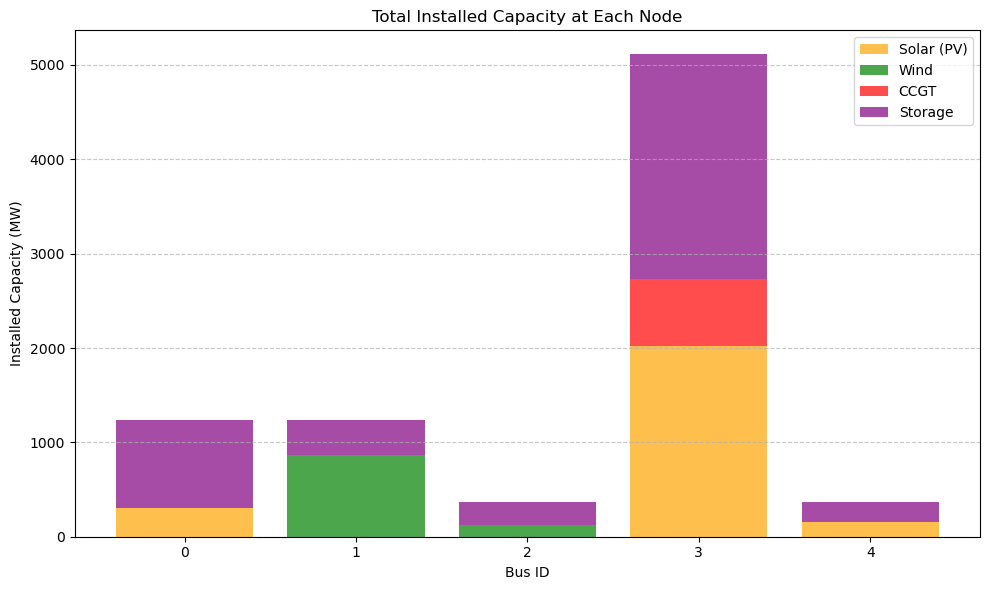

In [8]:
# Extract investments from the loaded results
pv_investment = np.array(list(loaded_results["inv"]["PV"].values()))
wind_investment = np.array(list(loaded_results["inv"]["Wind"].values()))
ccgt_investment = np.array(list(loaded_results["inv"]["CCGT"].values())) * params['CCGT Max Cap']
storage_investment = np.array(list(loaded_results["inv"]["Storage Energy"].values()))

# Calculate total capacity installed at each bus
# total_capacity = pv_investment + wind_investment + ccgt_investment + storage_investment

# Create a bar plot
bus_ids = range(len(pv_investment))  # Assuming buses are indexed from 0 to N-1
plt.figure(figsize=(10, 6))
# plt.bar(bus_ids, total_capacity, color='skyblue', label='Total Capacity (MW)')

# Add labels for individual components
plt.bar(bus_ids, pv_investment, color='orange', label='Solar (PV)', alpha=0.7)
plt.bar(bus_ids, wind_investment, bottom=pv_investment, color='green', label='Wind', alpha=0.7)
plt.bar(bus_ids, ccgt_investment, bottom=pv_investment + wind_investment, color='red', label='CCGT', alpha=0.7)
plt.bar(bus_ids, storage_investment, bottom=pv_investment + wind_investment + ccgt_investment, color='purple', label='Storage', alpha=0.7)

# Add plot details
plt.xlabel('Bus ID')
plt.ylabel('Installed Capacity (MW)')
plt.title('Total Installed Capacity at Each Node')
plt.xticks(bus_ids)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('installed_capacity.png', dpi=300)

# Show the plot
plt.show()

In [62]:
transmission_investment = np.array(list(loaded_results["inv"]["Tran"].values()))
transmission_investment

array([0.015, 0.039, 0.067, 0.101, 0.189, 0.01 , 0.044, 0.   , 0.001,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.051, 0.   ,
       0.001, 0.012, 0.004, 0.   , 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.092, 0.   , 0.002, 0.   , 0.005, 0.055,
       0.001, 0.002, 0.   , 0.121, 0.001, 0.005, 0.   , 0.009, 0.011,
       0.008, 0.005, 0.   , 0.112, 0.   , 0.001, 0.03 , 0.001, 0.   ,
       0.   , 0.033, 0.   , 0.002, 0.   , 0.001, 0.005, 0.002, 0.006,
       0.   , 0.002, 0.002, 0.   , 0.002, 0.005, 0.002, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

In [63]:
storage_investment

array([1.716, 2.783, 2.198, 0.122, 2.282, 4.654, 4.945, 1.659, 2.287,
       0.928])

In [45]:
zones = pd.read_csv('agg_bus.csv')
for ix, row in branches.iterrows():
    from_zone = row['from_zone']
    to_zone = row['to_zone']
    from_lat = zones[zones["zone_id"] == from_zone]["Lat"].iloc[0]  # Extract scalar value
    from_lon = zones[zones["zone_id"] == from_zone]["Lon"].iloc[0]  # Extract scalar value
    to_lat = zones[zones["zone_id"] == to_zone]["Lat"].iloc[0]      # Extract scalar value
    to_lon = zones[zones["zone_id"] == to_zone]["Lon"].iloc[0]      # Extract scalar value
    dist = harversine(from_lat, from_lon, to_lat, to_lon)
    branches.at[ix, "length"] = dist  # Update the original DataFrame

In [47]:
branches.to_csv('agg_branch.csv', index=False)

In [33]:
lines['in'], lines['out'] = {bus: [] for bus in buses}, {bus: [] for bus in buses}
for ix, row in branches.iterrows():
    lines['in'][row['to_zone']].append(ix)
    lines['out'][row['from_zone']].append(ix)

In [ ]:
pv2 = pd.read_csv('RTS-GMLC/RTS_Data/timeseries_data_files/PV/REAL_TIME_pv.csv')
pv2 = aggregate(pv2)
print(pv2.shape)
# pv2.dropna(axis=1).shape

(105408, 29)


In [10]:
# Check for NaN values in pv2
nan_locations = pv2.isna()  # Boolean DataFrame indicating where NaN values are
nan_count_per_column = pv2.isna().sum()  # Count of NaN values per column
total_nan_count = pv2.isna().sum().sum()  # Total count of NaN values in the DataFrame

# print("NaN locations (True indicates NaN):")
# print(nan_locations)

print("\nNaN count per column:")
print(nan_count_per_column)

print(f"\nTotal NaN count in pv2: {total_nan_count}")


NaN count per column:
Year        0
Month       0
Day         0
Period      0
320_PV_1    0
314_PV_1    0
314_PV_2    0
313_PV_1    0
314_PV_3    0
314_PV_4    0
313_PV_2    0
310_PV_1    0
324_PV_1    0
312_PV_1    0
310_PV_2    0
324_PV_2    0
324_PV_3    0
113_PV_1    0
319_PV_1    0
215_PV_1    0
102_PV_1    0
101_PV_1    0
102_PV_2    0
104_PV_1    0
101_PV_2    0
101_PV_3    0
101_PV_4    0
103_PV_1    0
119_PV_1    0
dtype: int64

Total NaN count in pv2: 0


In [39]:
load

101      102      103      104      105      106      107  \
Week Day Hour                                                                  
1    1   0     411.995  370.033  686.658  282.293  270.849  518.809  476.846   
         1     412.290  370.297  687.150  282.495  271.042  519.180  477.187   
         2     418.925  376.257  698.209  287.042  275.405  527.536  484.867   
         3     433.364  389.225  722.273  296.935  284.897  545.718  501.579   
         4     476.741  428.184  794.568  326.656  313.413  600.340  551.783   
...                ...      ...      ...      ...      ...      ...      ...   
52   364 19    572.723  514.390  954.539  392.421  376.512  721.207  662.874   
         20    555.323  498.763  925.539  380.499  365.074  699.296  642.735   
         21    519.356  466.459  865.593  355.855  341.428  654.004  601.106   
         22    476.581  428.041  794.302  326.546  313.308  600.139  551.599   
         23    452.091  406.045  753.485  309.766  297.208  569.300  523.253   

                   108      109       110  ...      316  317       318  \
Week Day Hour                              ...                           
1    1   0     652.325  667.584   743.880  ...  523.183  0.0  1742.201   
         1     652.792  668.062   744.412  ...  499.198  0.0  1662.329   
         2     663.299  678.814   756.393  ...  488.094  0.0  1625.352   
         3     686.160  702.210   782.463  ...  481.472  0.0  1603.302   
         4     754.840  772.497   860.782  ...  487.339  0.0  1622.838   
...                ...      ...       ...  ...      ...  ...       ...   
52   364 19    906.812  928.024  1034.084  ...  717.568  0.0  2389.503   
         20    879.262  899.829  1002.667  ...  703.791  0.0  2343.622   
         21    822.314  841.549   937.726  ...  669.660  0.0  2229.969   
         22    754.587  772.238   860.494  ...  616.798  0.0  2053.936   
         23    715.811  732.555   816.275  ...  568.465  0.0  1892.988   

                    319      320  321  322  323  324  325  
Week Day Hour                                              
1    1   0      946.962  669.675  0.0  0.0  0.0  0.0  0.0  
         1      903.548  638.973  0.0  0.0  0.0  0.0  0.0  
         2      883.450  624.760  0.0  0.0  0.0  0.0  0.0  
         3      871.465  616.284  0.0  0.0  0.0  0.0  0.0  
         4      882.083  623.794  0.0  0.0  0.0  0.0  0.0  
...                 ...      ...  ...  ...  ...  ...  ...  
52   364 19    1298.799  918.488  0.0  0.0  0.0  0.0  0.0  
         20    1273.861  900.852  0.0  0.0  0.0  0.0  0.0  
         21    1212.085  857.165  0.0  0.0  0.0  0.0  0.0  
         22    1116.404  789.501  0.0  0.0  0.0  0.0  0.0  
         23    1028.922  727.635  0.0  0.0  0.0  0.0  0.0  

[8784 rows x 73 columns]

In [12]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,10872.090113,13206.716417,14910.726644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.980764,0.971015,0.978647,0.977110
1,10879.872568,12970.298507,14227.139037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.981079,0.943851,0.981569,0.971729
2,11054.977813,12933.582088,13910.671595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.981535,0.906405,0.983985,0.917616
3,11435.993856,12917.014927,13721.956590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.978089,0.905687,0.981906,0.939609
4,12580.663328,13164.179105,13889.155396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.977038,0.963469,0.980614,0.968037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,15113.528273,17592.089552,20450.699906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.007802,0.162525,0.008597,0.006726
8780,14654.363409,17210.597016,20058.029254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.009963,0.242395,0.006855,0.006580
8781,13705.228126,16528.656719,19085.317711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.030016,0.182645,0.006799,0.006434
8782,12576.447833,15620.149253,17578.735452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.072203,0.170336,0.005844,0.009709


In [11]:
demand = pd.read_csv("county_demand_local_hourly_2013.csv")

In [15]:
demand = demand.iloc[:6*24, 1:11]

In [18]:
demand.to_csv("agg_demand.csv", index=False)

In [26]:
pv = pd.read_csv('RTS-GMLC/RTS_Data/timeseries_data_files/PV/REAL_TIME_pv.csv')
wind = pd.read_csv('RTS-GMLC/RTS_Data/timeseries_data_files/WIND/REAL_TIME_wind.csv')
gen = pd.read_csv('RTS-GMLC/RTS_Data/SourceData/gen.csv')
load = pd.read_csv('RTS-GMLC/RTS_Data/timeseries_data_files/Load/REAL_TIME_regional_Load.csv')
buses = pd.read_csv('RTS-GMLC/RTS_Data/SourceData/bus.csv')
branches = pd.read_csv('RTS-GMLC/RTS_Data/SourceData/branch.csv')

In [27]:
pv

,Year,Month,Day,Period,320_PV_1,314_PV_1,314_PV_2,313_PV_1,314_PV_3,314_PV_4,...,215_PV_1,102_PV_1,101_PV_1,102_PV_2,104_PV_1,101_PV_2,101_PV_3,101_PV_4,103_PV_1,119_PV_1
0,2020,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,1,1,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020,1,1,4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,1,1,5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105403,2020,12,31,284,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105404,2020,12,31,285,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105405,2020,12,31,286,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105406,2020,12,31,287,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
